# Hands-On NLP — Class 3

<span style="color:magenta">Group Names:</span>

* Carlos Cuevas Villarmín
* Javier Alejandro Lopetegui González
* José Felipe Espinosa Orjuela

## Outline

- Better vectors: Tf-idf

- Ngrams

- Text generation

In [26]:
import re
import collections
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn import decomposition, naive_bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [27]:
tqdm.pandas()

nltk.download("punkt")

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 4)

print("sklearn's version:", sklearn.__version__)    # 1.3.2
print("nltk's version:", nltk.__version__)          # 3.8.1
print("pandas's version:", pd.__version__)          # 2.1.4

sklearn's version: 1.3.0
nltk's version: 3.8.1
pandas's version: 2.1.4


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/javierlopetegui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
%config InlineBackend.figure_format="retina"  # For high DPI display

## Getting the data

In [29]:
DATA = Path("../data")

TEXT_P = DATA / "texts"

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps

In [30]:
data = []

for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


In [31]:
all_df = pd.DataFrame.from_records(data, index=["id"])
all_df = all_df.drop("robotics.stackexchange_0000005103")
all_df

,text,category,cat_id
id,,,
mythology.stackexchange_0000001634,Q:\n\nCan anyone identify what Chinese mytholo...,mythology,0
mythology.stackexchange_0000002329,Q:\n\nHave runes ever been used to bring someo...,mythology,0
mythology.stackexchange_0000001146,Q:\n\nDifferences in the Greek and Roman portr...,mythology,0
mythology.stackexchange_0000004770,"Q:\n\nWhich cultures have the concept of a ""tr...",mythology,0
mythology.stackexchange_0000000516,Q:\n\nWhy did Arawn choose Pwyll to fight Hafg...,mythology,0
...,...,...,...
portuguese.stackexchange_0000001017,"Q:\n\n""pois não"" has an affirmative connotatio...",portuguese,5
portuguese.stackexchange_0000004609,"Q:\n\nPor que ""Teiú"" tem acento?\n\nMonossílab...",portuguese,5
portuguese.stackexchange_0000000484,"Q:\n\nRegional usage of ""guitarra"" and ""violão...",portuguese,5


---
Here the initialization of `all_df` is done and you can jump to your favorite classification
___

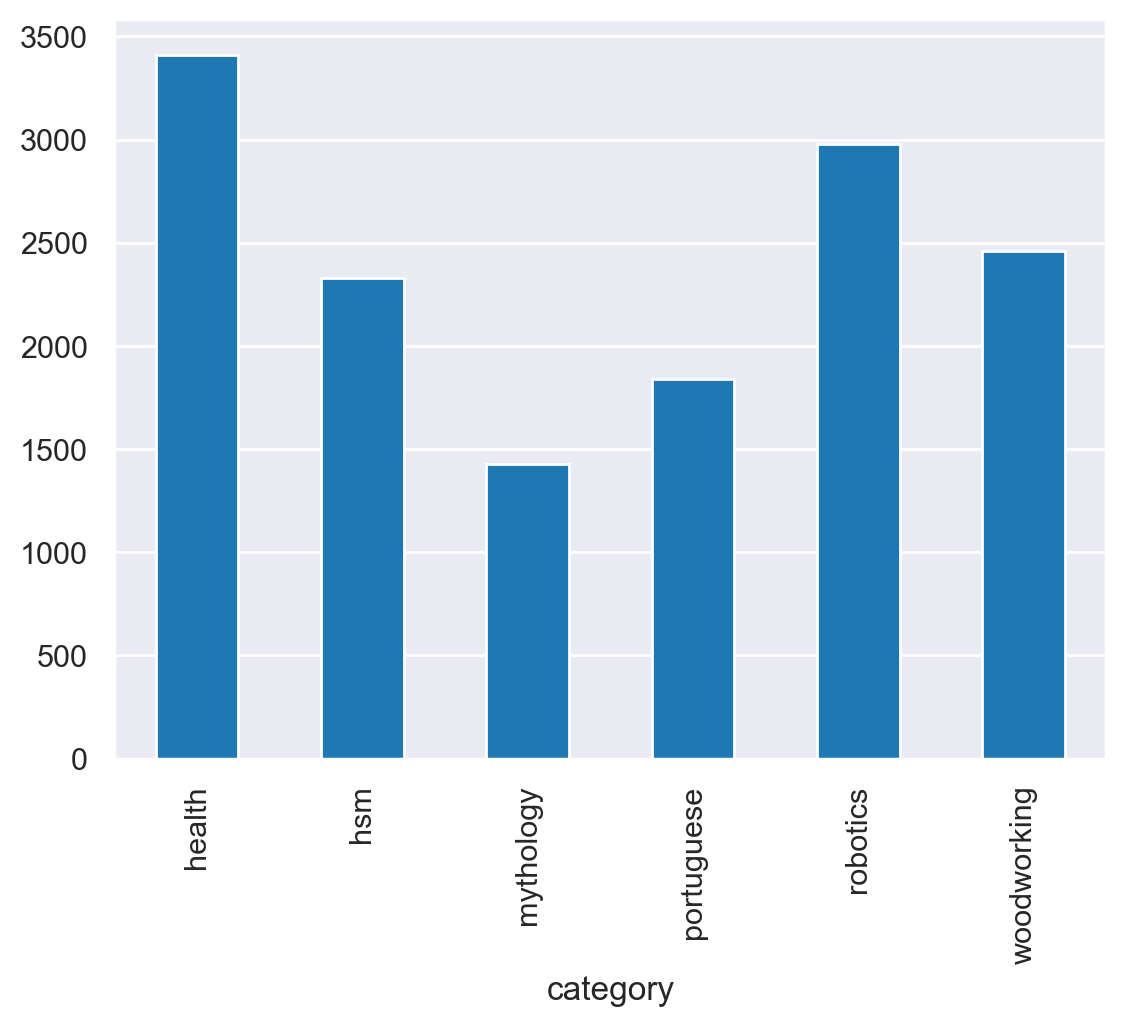

In [32]:
all_df.groupby("category").size().plot.bar()
plt.grid(axis="x")

## Vectorize

In [33]:
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

vectorizer = CountVectorizer()
xs = vectorizer.fit_transform(corpus).toarray()

cv_df = pd.DataFrame(xs, index=corpus, columns=vectorizer.get_feature_names_out())
cv_df

,and,document,first,is,one,second,the,third,this
This is the first document.,0,1,1,1,0,0,1,0,1
This document is the second document.,0,2,0,1,0,1,1,0,1
And this is the third one.,1,0,0,1,1,0,1,1,1
Is this the first document?,0,1,1,1,0,0,1,0,1


### TF-IDF

- The counting of words is not the ideal way to represent a document

- Instead of counting the number of occurences of a word, we could weight it by the number of documents it appears in

- Term Frequency - Inverse Document Frequency

#### From [Wikipedia](https://en.wikipedia.org/wiki/Tf-idf):

**Term frequency**

$$\operatorname{tf}(t,d) = \frac{f_{t,d}}{{\sum_{t' \in d}{f_{t',d}}}}$$

**Inverse document frequency**

$$\operatorname{idf}(t, D) =  - \log \frac{|\{d \in D: t \in d\}|}{N} = 
    -\log \left({\frac {n_{t}}{N}}\right) $$

N: total number of documents in the corpus $N = {|D|}$

**Smoothed IDF:**

$$\operatorname{idf}(t, D) = - \log \left( \frac {1 + n_t} {N}\right)+ 1$$

#### From [scikit-learn documentation](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting):

In `TfidfVectorizer`, the implementation is slightly different:

*   For the IDF:

    *   Unsmoothed version (`smooth_idf=False`), though a $+1$ is applied to avoid a value of 0 for the IDF:
    $$\operatorname{idf}(t, D) = -\log \left({\frac {n_{t}}{N}}\right) + 1$$

    *   Smoothed version (`smooth_idf=True`):
    $$\operatorname{idf}(t, D) = - \log \left( \frac {1 + n_t} {1 + N}\right)+ 1$$

*   `TFIDF = tf(t, d) * idf(t, D)`

*   `tf(t, d)` is the **count** of the term `t` in the document `d`, not the **frequency** (**no division!**)

*   Then a global normalization is applied: `TFIDF = TFIDF / norm(TFIDF)`
    
    (instead of a normalization within `tf` only to obtain a frequency)

*   `norm` is the L2 norm by default, but can be changed to L1 or `None`.

#### 🚧 TODO: Count vs. Freq vectorizers

Compare the previous results of the `CountVectorizer` with the `TfidfVectorizer` on the same toy dataset.

In [34]:
tf_idf = TfidfVectorizer() #smooth_idf=True
xs = tf_idf.fit_transform(corpus).toarray()

tf_idf_df = pd.DataFrame(xs, index=corpus, columns=tf_idf.get_feature_names_out())
tf_idf_df

,and,document,first,is,one,second,the,third,this
This is the first document.,0.0000,0.4698,0.5803,0.3841,0.0000,0.0000,0.3841,0.0000,0.3841
This document is the second document.,0.0000,0.6876,0.0000,0.2811,0.0000,0.5386,0.2811,0.0000,0.2811
And this is the third one.,0.5118,0.0000,0.0000,0.2671,0.5118,0.0000,0.2671,0.5118,0.2671
Is this the first document?,0.0000,0.4698,0.5803,0.3841,0.0000,0.0000,0.3841,0.0000,0.3841


### Let's now classify the StackOverflow documents in their respective corpus label

*   The complete corpus: `all_df`

*   Let's use the different vectorizers for representation

In [35]:
ys = all_df.cat_id.values

In [36]:
cv = CountVectorizer(max_features=5000)
xs = cv.fit_transform(all_df.text).toarray()

In [37]:
print("xs.shape =", xs.shape)
print("ys.shape =", ys.shape)

xs.shape = (14450, 5000)
ys.shape = (14450,)


In [38]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(10115, 5000)
(4335, 5000)


#### 🚧 TODO: `CountVectorizer` vs. `TfidfVectorizer` classifiers

*   Limit to the 5000 most frequent words to reduce the dimensionality

    (the sparse matrix `toarray()` method crashes if no reduction of features is applied)

*   Use both to classify the data based on, e.g., the `MultinomialNB` classifier

*   Compare their results in terms of accuracy and show their `classification_report`

THe CountVectorizer for max_features=5000 has already been fit and the data has been saved in xs variable. Notice that the label array ys will be the same independtly of the vectorizer chosen. Now, we do the same for TfidfVectorizer and split the data transformed into train and test set.

In [39]:
tf_idf = TfidfVectorizer(max_features=5000)
xs_tf = tf_idf.fit_transform(all_df.text).toarray()

print("xs_tf.shape =", xs_tf.shape)
print("ys.shape =", ys.shape)

train_xs_tf, test_xs_tf, train_ys, test_ys = train_test_split(
    xs_tf, ys, test_size=0.3, random_state=0, shuffle=True
)
print(f"Train set shape: {train_xs_tf.shape}")
print(f"Test set shape: {test_xs_tf.shape}")

xs_tf.shape = (14450, 5000)
ys.shape = (14450,)
Train set shape: (10115, 5000)
Test set shape: (4335, 5000)


In [44]:
#Define a DataFrame to save the results
metrics_df = pd.DataFrame(columns= ["train_accuracy","test_accuracy", "train_precision","test_precision", "train_recall","test_recall", "train_f1", "test_f1"])

In [52]:
from sklearn.metrics import precision_score, recall_score, f1_score

def TrainPredictModel(train_xs, train_ys, test_xs, model):
    '''
    Function that trains and predict given the model and data
    Args:
        train_xs: training data
        train_ys: training labels
        test_xs: test data
        model: model to be used
    Returns:
        List with the metrics
    '''
    print(f"Using: {type(model).__name__}")
    train_pred = model.fit(train_xs, train_ys)
    pred_train_ys = train_pred.predict(train_xs)
    pred_ys = model.predict(test_xs)
    print("Train accuracy:", accuracy_score(train_ys, pred_train_ys))
    print("Test accuracy:", accuracy_score(test_ys, pred_ys))

    return pred_ys, [accuracy_score(train_ys, pred_train_ys),accuracy_score(test_ys, pred_ys), 
            precision_score(train_ys, pred_train_ys, average="macro"),precision_score(test_ys, pred_ys, average="macro"), 
            recall_score(train_ys, pred_train_ys, average="macro"),recall_score(test_ys, pred_ys, average="macro"),
            f1_score(train_ys, pred_train_ys, average="macro"),f1_score(test_ys, pred_ys, average="macro")
            ]


In [53]:
print("Data with CountVectorizer")
pred_CV_MNB, metrics_df.loc['CountVectorizer_MNB'] = TrainPredictModel(train_xs, train_ys, test_xs, naive_bayes.MultinomialNB())
print("Data with TF-IDF")
pred_TF_MNB, metrics_df.loc['TF-IDF_MNB'] = TrainPredictModel(train_xs_tf, train_ys, test_xs_tf, naive_bayes.MultinomialNB())

Data with CountVectorizer
Using: MultinomialNB
Train accuracy: 0.9760751359367277
Test accuracy: 0.9741637831603229
Data with TF-IDF
Using: MultinomialNB
Train accuracy: 0.9769649036085022
Test accuracy: 0.9748558246828143


In [54]:
metrics_df

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1
CountVectorizer_MNB,0.9761,0.9742,0.9729,0.9727,0.9736,0.9723,0.9727,0.9721
TF-IDF_MNB,0.9770,0.9749,0.9770,0.9752,0.9736,0.9713,0.9751,0.9730


If we look the accuracy metric we see that MultinomialNB applied to TF-IDF tokenized data is slightly better than in the case of using CountVectorizer. Even when the difference is not too significative, tfd_idf could be a better metric to embed the relevance of the features in the texts as it consider more than just the frequency of the words in the documents but also the relevance in the corpus with the inverse document frequency term that penalize very common words among every corpus.

In [55]:
#Plot the classification report
print("Classification report for CountVectorizer")
print(classification_report(test_ys, pred_CV_MNB, target_names=CORPORA))
print("Classification report for TF-IDF")
print(classification_report(test_ys, pred_TF_MNB, target_names=CORPORA))

Classification report for CountVectorizer
              precision    recall  f1-score   support

   mythology       0.95      0.99      0.97       420
 woodworking       0.97      1.00      0.98       692
    robotics       0.98      0.97      0.98       935
         hsm       0.95      0.97      0.96       709
      health       0.98      0.98      0.98      1054
  portuguese       1.00      0.93      0.96       525

    accuracy                           0.97      4335
   macro avg       0.97      0.97      0.97      4335
weighted avg       0.97      0.97      0.97      4335

Classification report for TF-IDF
              precision    recall  f1-score   support

   mythology       0.97      0.96      0.97       420
 woodworking       0.97      1.00      0.98       692
    robotics       0.97      0.98      0.98       935
         hsm       0.95      0.97      0.96       709
      health       0.98      0.99      0.99      1054
  portuguese       1.00      0.93      0.97       525

  

In the classsification reports we can see that actually the precission improves in the tf_idf approach compare to the count vectorizer one, mostly for the mythology corpus. 

In order to look the reason of these minimal variation between the methodologies let see if there exist any difference in the vocabulary of both scenarios.

In [56]:
print(f"Vocabulary of CountVectorizer: \t{cv.get_feature_names_out()}")
print(f"Vocabulary of TF-IDF: \t\t{tf_idf.get_feature_names_out()}")

#Show the words of the vocabulary that just exist in one of the tokenizers
print(f"Words that just appear in one of the vocabularies:{set(cv.get_feature_names_out()) ^ set(tf_idf.get_feature_names_out())}")

Vocabulary of CountVectorizer: 	['00' '000' '01' ... 'água' 'ênfase' 'única']
Vocabulary of TF-IDF: 		['00' '000' '01' ... 'água' 'ênfase' 'única']
Words that just appear in one of the vocabularies:set()


As we can see the vocabulary is the same in both cases, so the difference is more related with the way each model use to calculate the entries of the vector.

#### 🚧 TODO: `MultinomialNB` vs. `GaussianNB` classifiers

*   Use both to classify the data

*   Compare their results in terms of accuracy and show their `classification_report`

In [57]:
print("Data with CountVectorizer")
pred_CV_GNB, metrics_df.loc['CountVectorizer_GNB'] = TrainPredictModel(train_xs, train_ys, test_xs, naive_bayes.GaussianNB())
print("Data with TF-IDF")
pred_TF_GNB, metrics_df.loc['TF-IDF_GNB'] = TrainPredictModel(train_xs_tf, train_ys, test_xs_tf, naive_bayes.GaussianNB())

Data with CountVectorizer
Using: GaussianNB
Train accuracy: 0.9803262481463173
Test accuracy: 0.9504036908881199
Data with TF-IDF
Using: GaussianNB
Train accuracy: 0.9939693524468611
Test accuracy: 0.952479815455594


In order to compare better the results we see the DataFrame defined.

In [58]:
metrics_df

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1
CountVectorizer_MNB,0.9761,0.9742,0.9729,0.9727,0.9736,0.9723,0.9727,0.9721
TF-IDF_MNB,0.9770,0.9749,0.9770,0.9752,0.9736,0.9713,0.9751,0.9730
CountVectorizer_GNB,0.9803,0.9504,0.9771,0.9475,0.9822,0.9509,0.9792,0.9490
TF-IDF_GNB,0.9940,0.9525,0.9931,0.9546,0.9943,0.9507,0.9937,0.9525


We can clearly see that in terms of accuracy using MultinomialNB the results are much better than using with GaussianNB. 

If we compare the metrics for training and test set for GaussianNB we can see clearly that there is overfiting because for the training test the model predict almost perfectly the distribution of the data while for the test set is significatively worse. Then, that is why the generalization is better for MultinomialNB. 

It can be explained from the fact that the complexity for the GaussianNB case is more than what the actual data distribution requires. The model in that case is very sensitive to the noise in the training data.

In [59]:
#Show the classification reports of the models
print("--Classification report for CountVectorizer and MultinomialNB--")
print(classification_report(test_ys, pred_CV_MNB, target_names=CORPORA))
print("--Classification report for TfidVectorizer and MultinomialNB--")
print(classification_report(test_ys, pred_TF_MNB, target_names=CORPORA))
print("--Classification report for CountVectorizer and GaussianNB--")
print(classification_report(test_ys, pred_CV_GNB, target_names=CORPORA))
print("--Classification report for TfidVectorizer and GaussianNB--")
print(classification_report(test_ys, pred_TF_GNB, target_names=CORPORA))

--Classification report for CountVectorizer and MultinomialNB--
              precision    recall  f1-score   support

   mythology       0.95      0.99      0.97       420
 woodworking       0.97      1.00      0.98       692
    robotics       0.98      0.97      0.98       935
         hsm       0.95      0.97      0.96       709
      health       0.98      0.98      0.98      1054
  portuguese       1.00      0.93      0.96       525

    accuracy                           0.97      4335
   macro avg       0.97      0.97      0.97      4335
weighted avg       0.97      0.97      0.97      4335

--Classification report for TfidVectorizer and MultinomialNB--
              precision    recall  f1-score   support

   mythology       0.97      0.96      0.97       420
 woodworking       0.97      1.00      0.98       692
    robotics       0.97      0.98      0.98       935
         hsm       0.95      0.97      0.96       709
      health       0.98      0.99      0.99      1054
  por

#### 🚧 TODO: Confusion matrix for the MultinomialNB classifier

- Verify in a confusion matrix that the precision of portuguese is 1.00 and its recall is about 0.93 with the `MultinomialNB` classifier on the Tfidf vectorizer

- Translate this result into a sentence

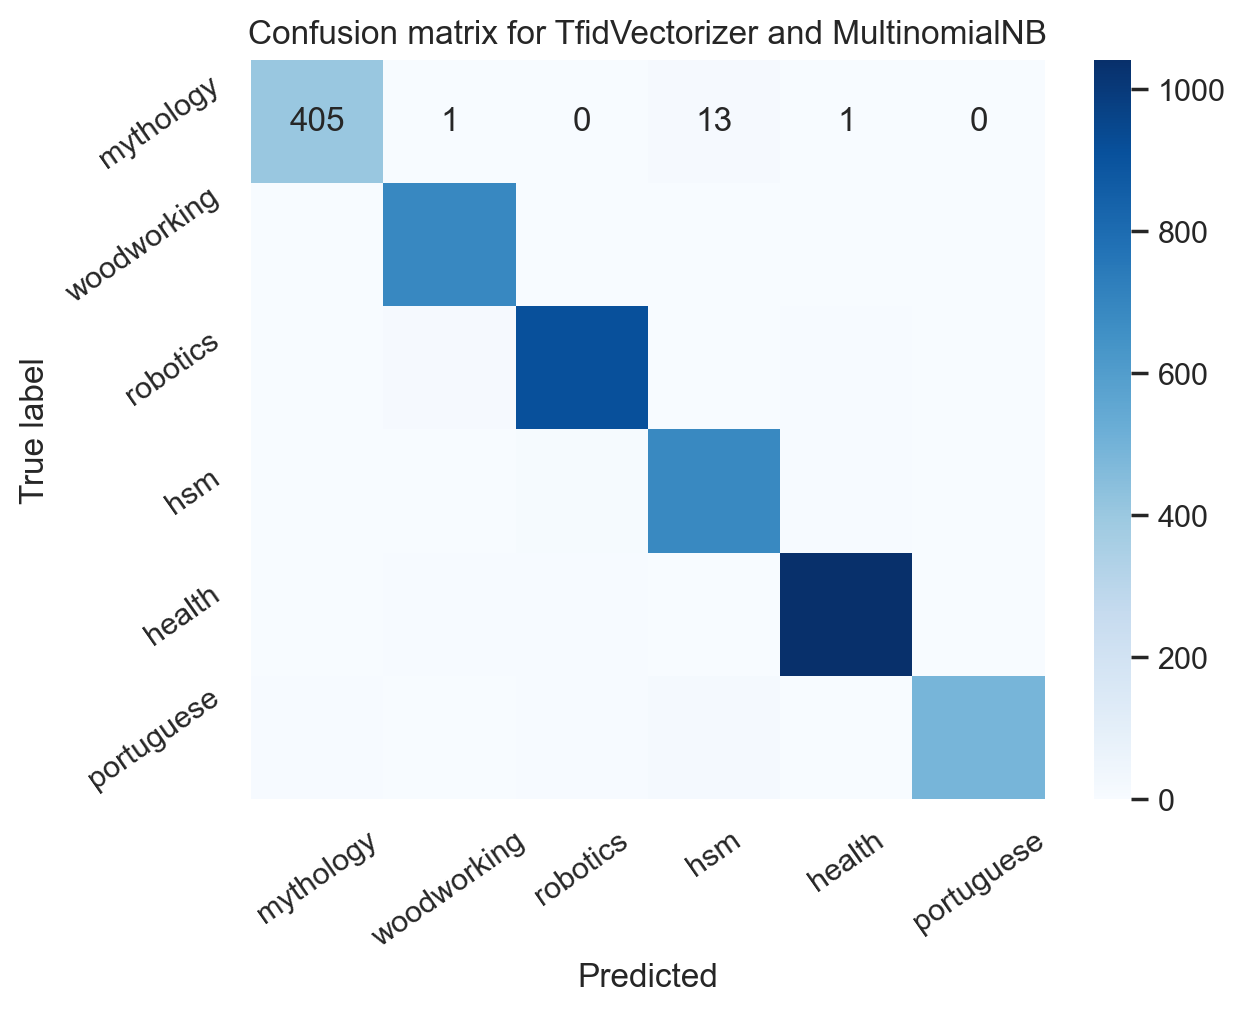

In [60]:
cm_tf_cv_mnb = confusion_matrix(test_ys, pred_TF_MNB)
sns.heatmap(cm_tf_cv_mnb, annot=True, fmt="d", xticklabels=CORPORA, yticklabels=CORPORA, cmap="Blues")
plt.xlabel("Predicted")
plt.xticks(rotation=35)
plt.ylabel("True label")
plt.yticks(rotation=35)
plt.title("Confusion matrix for TfidVectorizer and MultinomialNB")
plt.show()

There are not FP in Portuguese class so precision is 1 and the amount of FN is 32 so recall is about 0.94 as appears in the classification report.

#### 🚧 TODO: add the `stop_words="english"` option to the `tf_idf` vectorizer 

*   Compare the size of the `sparse_xs` for the 2 conditions (stop words included or not)

*   Retrain with the new vectorizer and the MultinomialNB classifier

*   Compare the results with the previous vectorizer

In [25]:
#Adding the stop_word to the tf_idf vectorizer
tf_idf_sw = TfidfVectorizer(stop_words="english", max_features=5000)
xs_tf_sw = tf_idf_sw.fit_transform(all_df.text).toarray()

print(f"xs.shape with stop word is {xs_tf_sw.shape}")
print(f"xs.shape without stop word is {xs_tf.shape}")

xs.shape with stop word is (14450, 5000)
xs.shape without stop word is (14450, 5000)


In [26]:
#Split the data for training
train_xs_tf_sw, test_xs_tf_sw, train_ys, test_ys = train_test_split(
    xs_tf_sw, ys, test_size=0.3, random_state=0, shuffle=True
)
print(f"Train set shape: {train_xs_tf_sw.shape}")
print(f"Test set shape: {test_xs_tf_sw.shape}")

Train set shape: (10115, 5000)
Test set shape: (4335, 5000)


In [27]:
pred_TF_MNB_SW, metrics_df.loc['TF-IDF_MNB_SW'] = TrainPredictModel(train_xs_tf_sw, train_ys, test_xs_tf_sw, naive_bayes.MultinomialNB())

Using: MultinomialNB
Train accuracy: 0.9794364804745428
Test accuracy: 0.9787773933102653


In [28]:
metrics_df.loc[["TF-IDF_MNB","TF-IDF_MNB_SW"]]

,accuracy,precision,recall,f1
TF-IDF_MNB,0.9772,0.9772,0.9745,0.9756
TF-IDF_MNB_SW,0.9788,0.9801,0.9774,0.9787


The results are better including the stop word "English". Why????????

In [29]:
print(f"Vocabulary of TF-IDF with stop words: \t{tf_idf_sw.get_feature_names_out()}")
print(f"Vocabulary of TF-IDF: \t\t\t{tf_idf.get_feature_names_out()}")

#Show the words of the vocabulary that just exist in one of the tokenizers
print(f"Words that just appear in the vocabulary with stop word:{set(tf_idf_sw.get_feature_names_out()) - set(tf_idf.get_feature_names_out())}")
print(f"Words that just appear in the vocabulary without stop word:{set(tf_idf.get_feature_names_out()) - set(tf_idf_sw.get_feature_names_out())}")

Vocabulary of TF-IDF with stop words: 	['00' '000' '01' ... 'última' 'último' 'única']
Vocabulary of TF-IDF: 			['00' '000' '01' ... 'água' 'ênfase' 'única']
Words that just appear in the vocabulary with stop word:{'ruled', 'judge', 'mythical', 'worn', 'neural', 'christ', '1908', 'linha', 'pmid', 'lever', 'entity', 'accordingly', 'urdf', 'protected', 'entretanto', 'molecule', 'elaborate', 'fifth', 'organization', 'theme', 'african', 'rabbet', 'uno', 'exceptions', '4th', 'seizures', 'grinding', 'pop', 'ethanol', 'coloured', 'choices', 'resulted', 'planks', 'hindu', 'destroy', 'rejected', 'twin', 'modify', 'contagious', 'foam', 'challenging', 'underside', 'revelation', 'conic', 'clouds', 'pool', 'rear', 'confidence', 'último', 'demonstrate', 'c_', 'accident', '77', 'demand', 'introducing', 'maintenance', 'io', 'figured', 'ultimate', 'magazine', 'illnesses', 'usam', 'revealed', 'accidentally', 'translates', 'supplementation', 'induce', 'capture', 'pushed', 'caries', 'employed', 'cbd', 'ma

In that case the difference in the vocabulary will affect to the results.

#### 🚧 TODO: PCA

*   Apply PCA to project on 2 dimensions to all vectors (train and test) and plot them

*   Compare the plot with the previous vectorizer with, and without the `stop_words="english"` option

*   Explain the difference breafly

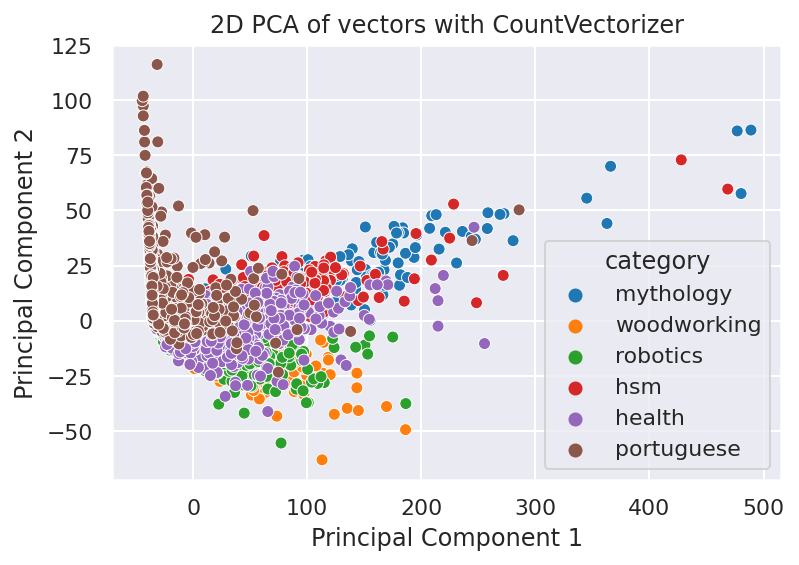

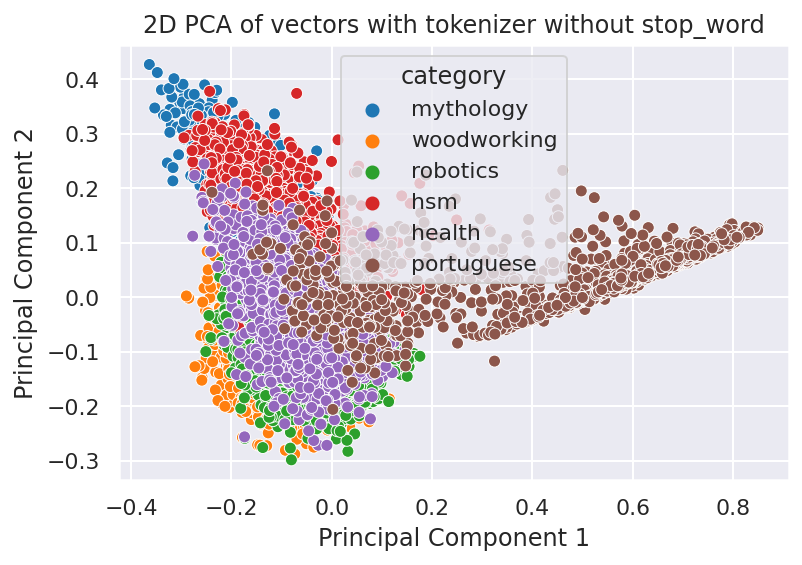

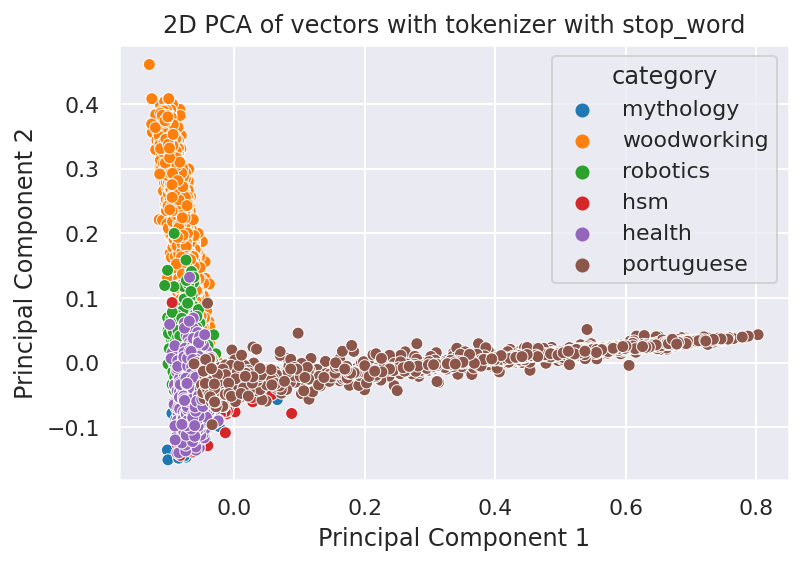

In [30]:
#Apply PCA to the data
pca = decomposition.PCA(n_components=2, random_state=42)

xs_pca = pca.fit_transform(xs)

sns.scatterplot(x=xs_pca[:, 0], y=xs_pca[:, 1], hue=all_df['category'], legend='full')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of vectors with CountVectorizer')
plt.grid(True)
plt.show()

xs_tf_pca = pca.fit_transform(xs_tf) #With tokenizer without stop_word
xs_tf_sw_pca = pca.fit_transform(xs_tf_sw) #With tokenizer with stop_word

sns.scatterplot(x=xs_tf_pca[:, 0], y=xs_tf_pca[:, 1], hue=all_df['category'], legend='full')    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of vectors with tokenizer without stop_word')
plt.grid(True)
plt.show()

sns.scatterplot(x=xs_tf_sw_pca[:, 0], y=xs_tf_sw_pca[:, 1], hue=all_df['category'], legend='full')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of vectors with tokenizer with stop_word')
plt.grid(True)
plt.show()

As we can clearly see portuguese is the most differenciated category if we consider stop_word="english" this is caused to the differences between both languages. While most of the text of the other categories will be probably written in English, the portuguese texts not so in that case the stop_word does not affect as much to this category as to the others.

#### 🚧 TODO: Train on PCA

*   Apply PCA to project on 2 dimensions to all vectors (train and test), fitting the PCA only on the training set

*   Train the MultinomialNB and the GaussianNB classifiers on the PCA vectors

    Does it work with both classifiers? Explain breafly.

*   Compare the results with the vectorizer with, and without, the `stop_words="english"` option

*   Analyze the difference breafly

In [31]:
# Apply PCA to the data fitting only on the training data
pca = decomposition.PCA(n_components=2, random_state=42)

train_xs_pca_tf = pca.fit_transform(train_xs_tf) #With tokenizer without stop_word
test_xs_pca_tf = pca.transform(test_xs_tf)

train_xs_pca_tf

train_xs_pca_tf_sw = pca.fit_transform(train_xs_tf_sw) #With tokenizer with stop_word
test_xs_pca_tf_sw = pca.transform(test_xs_tf_sw)

In [32]:
#Train the model with the new data
pred_TF_MNB_PCA, metrics_df.loc['TF-IDF_MNB_PCA'] = TrainPredictModel(train_xs_pca_tf, train_ys, test_xs_pca_tf, naive_bayes.MultinomialNB())
pred_TF_MNB_PCA_SW, metrics_df.loc['TF-IDF_MNB_PCA_SW'] = TrainPredictModel(train_xs_pca_tf_sw, train_ys, test_xs_pca_tf_sw, naive_bayes.MultinomialNB())

Using: MultinomialNB


ValueError: Negative values in data passed to MultinomialNB (input X)

With MultinomialNB model we cannot train with PCA vectors because we pass negative values.

In [33]:
pred_TF_GNB_PCA, metrics_df.loc['TF-IDF_GNB_PCA'] = TrainPredictModel(train_xs_pca_tf, train_ys, test_xs_pca_tf, naive_bayes.GaussianNB())
pred_TF_GNB_PCA_SW, metrics_df.loc['TF-IDF_GNB_PCA_SW'] = TrainPredictModel(train_xs_pca_tf_sw, train_ys, test_xs_pca_tf_sw, naive_bayes.GaussianNB())

Using: GaussianNB
Train accuracy: 0.6006920415224913
Test accuracy: 0.5810841983852364
Using: GaussianNB
Train accuracy: 0.6473554127533366
Test accuracy: 0.6348327566320646


/home/carlos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now we compare the results training with PCA vectors, with and without stop word. We also add the best results achieve (with multinomialNB and TF-IDF) to compare the new results after applying PCA with the previous ones.

In [34]:
metrics_df.loc[["TF-IDF_MNB","TF-IDF_MNB_SW", "TF-IDF_GNB_PCA", "TF-IDF_GNB_PCA_SW"]]

,accuracy,precision,recall,f1
TF-IDF_MNB,0.9772,0.9772,0.9745,0.9756
TF-IDF_MNB_SW,0.9788,0.9801,0.9774,0.9787
TF-IDF_GNB_PCA,0.5811,0.6145,0.5783,0.5875
TF-IDF_GNB_PCA_SW,0.6348,0.5857,0.6002,0.5870


We can see that the results are bad training with PCA, reducing the features to just two values is translated into low information to learn well the patterns.

#### 🚧 TODO: PCA with more dimensions

*   Try to find the best number of dimensions for the PCA with [`GridSearchCV`](sklearn.model_selection.GridSearchCV)

*   Use pipeline to combine the PCA and the classifier and other potential preprocessing steps

*   Boxplot accuracyies for different PCA dimension values using 

## N-grams features for text classification

*   We will use bigram in this section

In [35]:
vectorizer_2g = CountVectorizer(
    analyzer="word", ngram_range=(2, 2), max_features=5000,
)
x2gs = vectorizer_2g.fit_transform(all_df.text).toarray()

In [36]:
pd.DataFrame(vectorizer_2g.get_feature_names_out(), columns=["bigrams"])

,bigrams
0,17th century
1,18th century
2,19th century
3,20th century
4,24 hours
...,...
4995,your question
4996,your robot
4997,your system
4998,youtube com


In [37]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    x2gs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(10115, 5000)
(4335, 5000)


#### 🚧 TODO: Train classification models on n-grams

*   Train on the `CountVectorizer` with ngrams using the `MultinomialNB` classifier

*   Compare the results with the previous "raw" `CountVectorizer`

In [38]:
pred_CV_MNB_2g, metrics_df.loc['CountVectorizer_MNB_2g'] = TrainPredictModel(train_xs, train_ys, test_xs, naive_bayes.MultinomialNB())

Using: MultinomialNB
Train accuracy: 0.9505684626791894
Test accuracy: 0.9411764705882353


In [39]:
metrics_df.loc[['CountVectorizer_MNB', 'CountVectorizer_MNB_2g']]

,accuracy,precision,recall,f1
CountVectorizer_MNB,0.9762,0.9731,0.9745,0.9733
CountVectorizer_MNB_2g,0.9412,0.9383,0.9379,0.9377


---
## Building an n-gram generator
___

### Let's build character trigrams first

In [40]:
LINE = "This is cool!"
N = 3
[LINE[i : i + N] for i in range(len(LINE) - N + 1)]

['Thi', 'his', 'is ', 's i', ' is', 'is ', 's c', ' co', 'coo', 'ool', 'ol!']

In [41]:
[tuple(LINE[i : i + N]) for i in range(len(LINE) - N + 1)]

[('T', 'h', 'i'),
 ('h', 'i', 's'),
 ('i', 's', ' '),
 ('s', ' ', 'i'),
 (' ', 'i', 's'),
 ('i', 's', ' '),
 ('s', ' ', 'c'),
 (' ', 'c', 'o'),
 ('c', 'o', 'o'),
 ('o', 'o', 'l'),
 ('o', 'l', '!')]

In [42]:
LINES = """This is cool!
This is amazing!
But why is this his fish?"""

re.split("\n+", LINES.lower())

['this is cool!', 'this is amazing!', 'but why is this his fish?']

In [43]:
ngrams = collections.Counter()

for line in re.split("\n+", LINES.lower()):
    ngrams.update([line[i : i + N] for i in range(len(line) - N + 1)])

nc_df = pd.DataFrame.from_dict(
    ngrams, orient="index", columns=["freq"]
).sort_values("freq", ascending=False)

nc_df.head(7)

,freq
is,7
his,4
thi,3
is,3
s i,2
th,1
wh,1


### Back to our corpora

#### 🚧 TODO: Build an ngram generator for the `"woodworking"` corpus

*   Tokenize the corpus first with `nltk.word_tokenize`

*   Normalize the tokens by simply simply lowercasing them

*   Give the tokens frequency to the ngram generator

In [44]:
wood_df = all_df[all_df.category == "woodworking"]
wood_df.head()

,text,category,cat_id
id,,,
woodworking.stackexchange_0000006012,Q:\n\nTool recommendation to prick bamboo node...,woodworking,1
woodworking.stackexchange_0000009613,Q:\n\nHow to produce lumber from logs?\n\nI ha...,woodworking,1
woodworking.stackexchange_0000012922,Q:\n\nHow to fix warped wood in cane chair hid...,woodworking,1
woodworking.stackexchange_0000004242,Q:\n\nIs a long router bit safe?\n\nThere are ...,woodworking,1
woodworking.stackexchange_0000000067,Q:\n\nHow can I store hand tools so they won't...,woodworking,1


In [45]:
wood_txt = wood_df.iloc[0].text
print(wood_txt[:333])

Q:

Tool recommendation to prick bamboo nodes

I am looking for some kind of tool which I can use to prick through a bamboo.
To be more specific, bamboo is hollow inside. There is just some kind of plates "the nodes" which is connecting the inside. I want to prick these nodes, so the bamboo is hollow in full.
The bamboo I work with


#### 🚧 TODO: Text generation with ngrams

*   Generate a text of words until a stop word is generated (`.`)

*   Assign a probability to each ngrams based on their frequency

*   Sample from the ngrams based on their probability

*   Try different starting words (use bigrams)

 *Note:* [`default_rng`](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng) is the recommended constructor for random number generation in NumPy.

### TODO (optional): Improve this algorithm

- Try to fix some possible issues, by handeling exceptions

- Improve the output spacing (no space before comma, etc.) and maybe handle the upper case

- Try on a different domain of our corpus

---